In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import logistic_regresion as lr
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'absolute'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']

vocab_dep = st.Vocabulary(data['train'],encoding_type)

vectorizer = TfidfVectorizer()

vectorizer.fit_transform(list(convai_train.keys()))

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_train,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_val,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,tfidf=True,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,tfidf=True,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn2(md_data,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,tfidf=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [13]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [14]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6810290447926272 	 Validation loss: 0.6804437293844708 	 
  1%|          | 574/57400 [00:17<31:56, 29.66it/s]
Epoch 2 	 Training loss: 0.6741272350221561 	 Validation loss: 0.6725845680398456 	 
  2%|▏         | 1148/57400 [00:29<17:58, 52.16it/s]
Epoch 3 	 Training loss: 0.6679460531950828 	 Validation loss: 0.6687618342496581 	 
  3%|▎         | 1722/57400 [00:40<15:21, 60.39it/s]
Epoch 4 	 Training loss: 0.6638757934346017 	 Validation loss: 0.6655232108245461 	 
  4%|▍         | 2296/57400 [00:50<15:27, 59.41it/s]
Epoch 5 	 Training loss: 0.6605748078341268 	 Validation loss: 0.6622946070412458 	 
  5%|▌         | 2870/57400 [00:58<12:36, 72.11it/s]
Epoch 6 	 Training loss: 0.6577219450099958 	 Validation loss: 0.6601410902152627 	 
  6%|▌         | 3444/57400 [01:07<12:20, 72.84it/s]
Epoch 7 	 Training loss: 0.6550543649894435 	 Validation loss: 0.657007055767512 	 
  7%|▋         | 4018/57400 [01:15<13:10, 67.51it/s]
Epoch 8 	 Training loss: 0.652302212

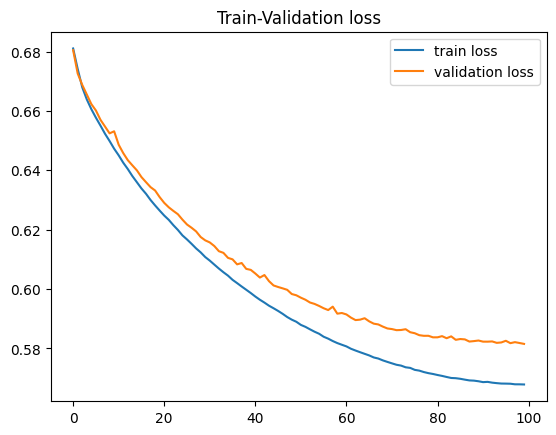

In [15]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about1'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6262755102040817, 'precision': 0.6262755102040817, 'f1': 0.6262755102040817, 'accuracy': 0.6262755102040817}
MALE {'recall': 0.8932291666666666, 'precision': 0.8932291666666666, 'f1': 0.8932291666666666, 'accuracy': 0.8932291666666666}
FEMALE {'recall': 0.37, 'precision': 0.37, 'f1': 0.37, 'accuracy': 0.37} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.571969696969697, 'precision': 0.571969696969697, 'f1': 0.571969696969697, 'accuracy': 0.571969696969697}
MALE {'recall': 0.8248175182481752, 'precision': 0.8248175182481752, 'f1': 0.8248175182481752, 'accuracy': 0.8248175182481752}
FEMALE {'recall': 0.2992125984251969, 'precision': 0.2992125984251969, 'f1': 0.2992125984251969, 'accuracy': 0.2992125984251969} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5358539765319427, 'precision': 0.5358539765319427, 'f1': 0.5358539765319427, 'accuracy': 0.5358539765319427}
MALE {'recall': 0.7676767676

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808310135524032 	 Validation loss: 0.6806034950886742 	 
  1%|          | 574/57400 [00:08<13:30, 70.14it/s]
Epoch 2 	 Training loss: 0.6739327194175654 	 Validation loss: 0.6720827555252333 	 
  2%|▏         | 1148/57400 [00:17<13:17, 70.54it/s]
Epoch 3 	 Training loss: 0.6678173208693594 	 Validation loss: 0.6678068284261025 	 
  3%|▎         | 1722/57400 [00:26<13:11, 70.36it/s]
Epoch 4 	 Training loss: 0.6637798936109509 	 Validation loss: 0.6648888527336767 	 
  4%|▍         | 2296/57400 [00:35<12:52, 71.30it/s]
Epoch 5 	 Training loss: 0.6605651988177349 	 Validation loss: 0.6612234721749516 	 
  5%|▌         | 2870/57400 [00:44<13:02, 69.71it/s]
Epoch 6 	 Training loss: 0.6574097378536384 	 Validation loss: 0.6583794072522955 	 
  6%|▌         | 3444/57400 [00:53<13:04, 68.74it/s]
Epoch 7 	 Training loss: 0.6546712056684992 	 Validation loss: 0.6559580615011312 	 
  7%|▋         | 4018/57400 [01:01<12:32, 70.92it/s]
Epoch 8 	 Training loss: 0.65200106

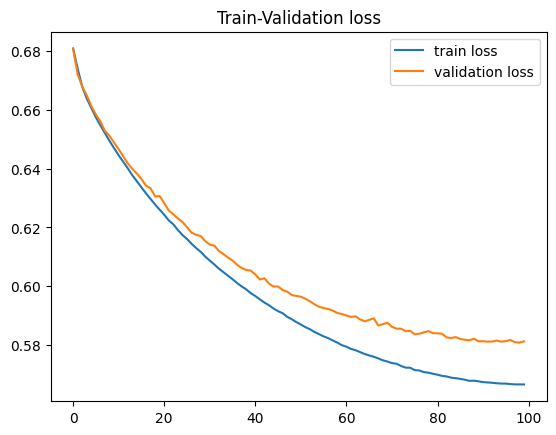

In [17]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about2'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6211734693877551, 'precision': 0.6211734693877551, 'f1': 0.6211734693877551, 'accuracy': 0.6211734693877551}
MALE {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
FEMALE {'recall': 0.395, 'precision': 0.395, 'f1': 0.395, 'accuracy': 0.395} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5656565656565656, 'precision': 0.5656565656565656, 'f1': 0.5656565656565656, 'accuracy': 0.5656565656565656}
MALE {'recall': 0.7858880778588808, 'precision': 0.7858880778588808, 'f1': 0.7858880778588808, 'accuracy': 0.7858880778588808}
FEMALE {'recall': 0.32808398950131235, 'precision': 0.32808398950131235, 'f1': 0.32808398950131235, 'accuracy': 0.32808398950131235} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5580182529335072, 'precision': 0.5580182529335072, 'f1': 0.5580182529335072, 'accuracy': 0.5580182529335072}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6811739742132845 	 Validation loss: 0.6806154382430901 	 
  1%|          | 574/57400 [00:08<13:12, 71.67it/s]
Epoch 2 	 Training loss: 0.6756918909034663 	 Validation loss: 0.6741655085046413 	 
  2%|▏         | 1148/57400 [00:17<13:22, 70.10it/s]
Epoch 3 	 Training loss: 0.6677631592501331 	 Validation loss: 0.6679868607197778 	 
  3%|▎         | 1722/57400 [00:26<13:06, 70.76it/s]
Epoch 4 	 Training loss: 0.6624771409541472 	 Validation loss: 0.6634416701429982 	 
  4%|▍         | 2296/57400 [00:35<12:36, 72.84it/s]
Epoch 5 	 Training loss: 0.6587976828892472 	 Validation loss: 0.660295867313773 	 
  5%|▌         | 2870/57400 [00:44<13:16, 68.46it/s]
Epoch 6 	 Training loss: 0.6555306498181944 	 Validation loss: 0.6574654983261884 	 
  6%|▌         | 3444/57400 [00:53<12:41, 70.83it/s]
Epoch 7 	 Training loss: 0.6526766615669902 	 Validation loss: 0.6542968931844679 	 
  7%|▋         | 4018/57400 [01:01<12:23, 71.81it/s]
Epoch 8 	 Training loss: 0.649860356

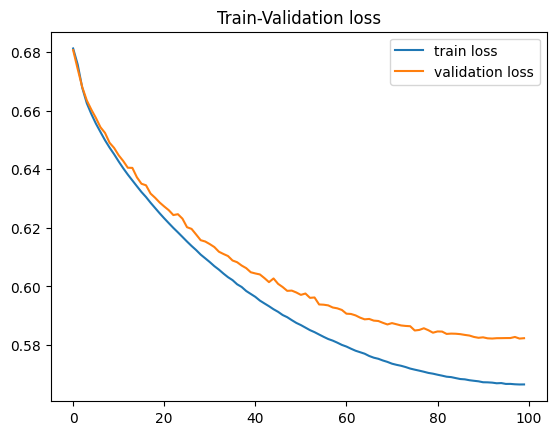

In [19]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about3'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6173469387755102, 'precision': 0.6173469387755102, 'f1': 0.6173469387755102, 'accuracy': 0.6173469387755102}
MALE {'recall': 0.8802083333333334, 'precision': 0.8802083333333334, 'f1': 0.8802083333333334, 'accuracy': 0.8802083333333334}
FEMALE {'recall': 0.365, 'precision': 0.365, 'f1': 0.36499999999999994, 'accuracy': 0.365} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5492424242424242, 'precision': 0.5492424242424242, 'f1': 0.5492424242424242, 'accuracy': 0.5492424242424242}
MALE {'recall': 0.8004866180048662, 'precision': 0.8004866180048662, 'f1': 0.8004866180048662, 'accuracy': 0.8004866180048662}
FEMALE {'recall': 0.2782152230971129, 'precision': 0.2782152230971129, 'f1': 0.2782152230971129, 'accuracy': 0.2782152230971129} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5488917861799217, 'precision': 0.5488917861799217, 'f1': 0.5488917861799217, 'accuracy': 0.5488917861799217}
MALE {

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6215986394557823, 'precision': 0.6215986394557823, 'f1': 0.6215986394557823, 'accuracy': 0.6215986394557823}
Métricas etiqueta male: {'recall': 0.8767361111111112, 'precision': 0.8767361111111112, 'f1': 0.8767361111111112, 'accuracy': 0.8767361111111112}
Métricas etiqueta female:  {'recall': 0.37666666666666665, 'precision': 0.37666666666666665, 'f1': 0.37666666666666665, 'accuracy': 0.37666666666666665}

 to
Resultado global: {'recall': 0.5622895622895623, 'precision': 0.5622895622895623, 'f1': 0.5622895622895623, 'accuracy': 0.5622895622895623}
Métricas etiqueta male: {'recall': 0.8037307380373074, 'precision': 0.8037307380373074, 'f1': 0.8037307380373074, 'accuracy': 0.8037307380373074}
Métricas etiqueta female:  {'recall': 0.3018372703412074, 'precision': 0.3018372703412074, 'f1': 0.3018372703412074, 'accuracy': 0.3018372703412074}

 as
Resultado global: {'recall': 0.5475880052151239, 'precision': 0.5475880052151239, 'f1':

# TO

In [22]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931467492405962 	 Validation loss: 0.6925982166144807 	 
  1%|          | 574/57400 [00:10<15:23, 61.51it/s]
Epoch 2 	 Training loss: 0.6930691101409833 	 Validation loss: 0.6928520647145934 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<14:56, 62.72it/s]
Epoch 3 	 Training loss: 0.6929945608257001 	 Validation loss: 0.6927727824550564 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:15, 60.85it/s]
Epoch 4 	 Training loss: 0.6929159142622133 	 Validation loss: 0.6928231231236862 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:42, 62.44it/s]
Epoch 5 	 Training loss: 0.6928235797101197 	 Validation loss: 0.692801660400326 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:51<16:30, 55.04it/s]
Epoch 6 	 Training loss: 0.6928104705303804 	 Validation loss: 0.6929573679374437 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [01:02<15:24, 58.33it/s]
Epoch 7 	 Training loss: 0.69

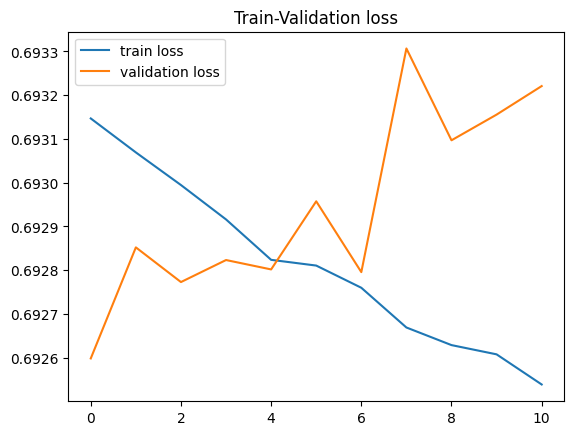

In [23]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to1'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.07552083333333333, 'precision': 0.07552083333333333, 'f1': 0.07552083333333333, 'accuracy': 0.07552083333333333}
FEMALE {'recall': 0.92, 'precision': 0.92, 'f1': 0.92, 'accuracy': 0.92} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.0705596107055961, 'precision': 0.0705596107055961, 'f1': 0.0705596107055961, 'accuracy': 0.0705596107055961}
FEMALE {'recall': 0.9422572178477691, 'precision': 0.9422572178477691, 'f1': 0.9422572178477691, 'accuracy': 0.9422572178477691} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930809760342908 	 Validation loss: 0.6924751188795445 	 
  1%|          | 574/57400 [00:10<15:40, 60.45it/s]
Epoch 2 	 Training loss: 0.6931194892536057 	 Validation loss: 0.6930253556219198 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:32, 60.32it/s]
Epoch 3 	 Training loss: 0.6929999103944892 	 Validation loss: 0.6931566050497152 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:53, 62.32it/s]
Epoch 4 	 Training loss: 0.6928616629244974 	 Validation loss: 0.6931677551592811 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:39, 58.63it/s]
Epoch 5 	 Training loss: 0.692879107355656 	 Validation loss: 0.6930245555053323 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:51<14:29, 62.71it/s]
Epoch 6 	 Training loss: 0.6927097164587692 	 Validation loss: 0.6925457726090641 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [01:01<14:48, 60.74it/s]
Epoch 7 	 Training loss: 0.69

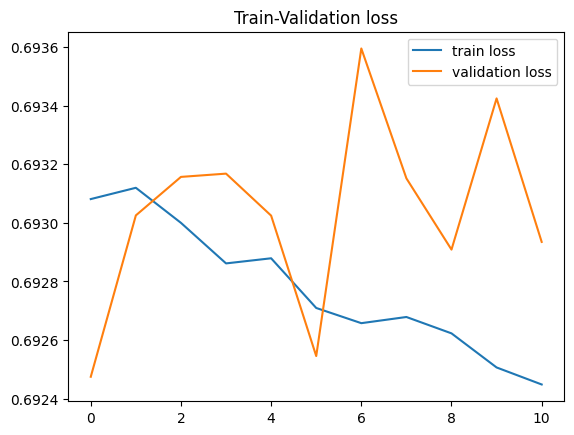

In [25]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to2'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.0078125, 'precision': 0.0078125, 'f1': 0.0078125, 'accuracy': 0.0078125}
FEMALE {'recall': 0.985, 'precision': 0.985, 'f1': 0.985, 'accuracy': 0.985} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.004866180048661801, 'precision': 0.004866180048661801, 'f1': 0.004866180048661801, 'accuracy': 0.004866180048661801}
FEMALE {'recall': 0.994750656167979, 'precision': 0.994750656167979, 'f1': 0.994750656167979, 'accuracy': 0.994750656167979} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.012626262626262626, 'precision': 0.012

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931369969238388 	 Validation loss: 0.6926950852749711 	 
  1%|          | 574/57400 [00:10<15:52, 59.69it/s]
Epoch 2 	 Training loss: 0.6931063216114709 	 Validation loss: 0.6928729667501935 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:17, 61.30it/s]
Epoch 3 	 Training loss: 0.6929919924262509 	 Validation loss: 0.6928240212343507 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:42, 63.11it/s]
Epoch 4 	 Training loss: 0.6929699919780372 	 Validation loss: 0.6930697974512132 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:44, 62.29it/s]
Epoch 5 	 Training loss: 0.6928570345303738 	 Validation loss: 0.6927718974776187 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:50<14:13, 63.92it/s]
Epoch 6 	 Training loss: 0.6927740328818663 	 Validation loss: 0.6934963060637652 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:22, 62.54it/s]
Epoch 7 	 Training loss: 0.6

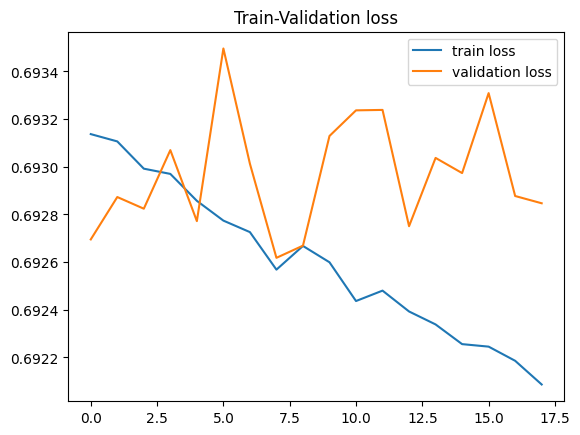

In [27]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to3'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.46938775510204084, 'precision': 0.46938775510204084, 'f1': 0.46938775510204084, 'accuracy': 0.46938775510204084}
MALE {'recall': 0.22135416666666666, 'precision': 0.22135416666666666, 'f1': 0.22135416666666666, 'accuracy': 0.22135416666666666}
FEMALE {'recall': 0.7075, 'precision': 0.7075, 'f1': 0.7075, 'accuracy': 0.7075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5088383838383839, 'precision': 0.5088383838383839, 'f1': 0.5088383838383839, 'accuracy': 0.5088383838383839}
MALE {'recall': 0.27007299270072993, 'precision': 0.27007299270072993, 'f1': 0.27007299270072993, 'accuracy': 0.27007299270072993}
FEMALE {'recall': 0.7664041994750657, 'precision': 0.7664041994750657, 'f1': 0.7664041994750657, 'accuracy': 0.7664041994750657} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49404761904761907, 'precision': 0.49404761904761907, 'f1': 0.49404761904761907, 'accuracy': 0.49404761904761907}
Métricas etiqueta male: {'recall': 0.1015625, 'precision': 0.1015625, 'f1': 0.1015625, 'accuracy': 0.1015625}
Métricas etiqueta female:  {'recall': 0.8708333333333333, 'precision': 0.8708333333333333, 'f1': 0.8708333333333333, 'accuracy': 0.8708333333333333}

 to
Resultado global: {'recall': 0.4932659932659933, 'precision': 0.4932659932659933, 'f1': 0.4932659932659933, 'accuracy': 0.4932659932659933}
Métricas etiqueta male: {'recall': 0.1151662611516626, 'precision': 0.1151662611516626, 'f1': 0.1151662611516626, 'accuracy': 0.1151662611516626}
Métricas etiqueta female:  {'recall': 0.9011373578302713, 'precision': 0.9011373578302713, 'f1': 0.9011373578302713, 'accuracy': 0.9011373578302713}

 as
Resultado global: {'recall': 0.494567579313342, 'precision': 0.494567579313342, 'f1': 0.494567579313342, 'accuracy': 0.4945

# AS

In [30]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930833806767281 	 Validation loss: 0.6930028351686769 	 
  1%|          | 574/57400 [00:09<14:42, 64.37it/s]
Epoch 2 	 Training loss: 0.6929420795590204 	 Validation loss: 0.6932677677122213 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<15:03, 62.29it/s]
Epoch 3 	 Training loss: 0.6927427552926 	 Validation loss: 0.6929640951803175 	 
  3%|▎         | 1722/57400 [00:29<14:52, 62.37it/s]
Epoch 4 	 Training loss: 0.6925400666866568 	 Validation loss: 0.6926838957657249 	 
  4%|▍         | 2296/57400 [00:39<15:07, 60.73it/s]
Epoch 5 	 Training loss: 0.6923523232704256 	 Validation loss: 0.6927808341333421 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:17, 63.56it/s]
Epoch 6 	 Training loss: 0.692190642556247 	 Validation loss: 0.6928692530777495 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:28, 62.13it/s]
Epoch 7 	 Training loss: 0.6920122048373006 	 Validation loss: 0.6928799849445537 	 

3 ep

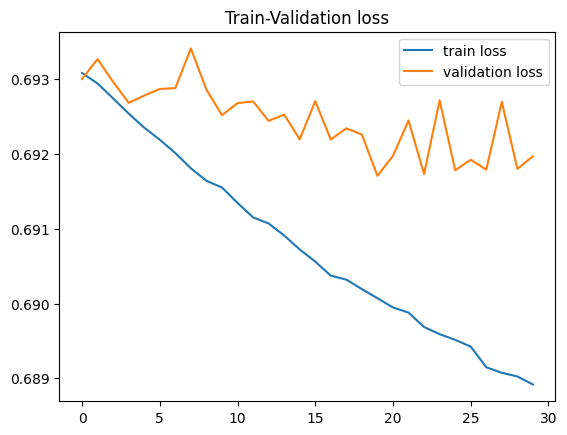

In [31]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as1'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49744897959183676, 'precision': 0.49744897959183676, 'f1': 0.49744897959183676, 'accuracy': 0.49744897959183676}
MALE {'recall': 0.3828125, 'precision': 0.3828125, 'f1': 0.3828125, 'accuracy': 0.3828125}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5921717171717171, 'precision': 0.5921717171717171, 'f1': 0.5921717171717171, 'accuracy': 0.5921717171717171}
MALE {'recall': 0.5206812652068127, 'precision': 0.5206812652068127, 'f1': 0.5206812652068127, 'accuracy': 0.5206812652068127}
FEMALE {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6205997392438071, 'precision': 0.6205997392438071, 'f1': 0.6205997392438071, 'accuracy': 0.6205997392438071}
MALE {'recall': 0.4595959595959596, 'precision':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930815467435724 	 Validation loss: 0.6931629665827347 	 
  1%|          | 574/57400 [00:09<15:06, 62.69it/s]
Epoch 2 	 Training loss: 0.692953970789494 	 Validation loss: 0.6928952164569143 	 
  2%|▏         | 1148/57400 [00:19<14:57, 62.69it/s]
Epoch 3 	 Training loss: 0.6927362475868717 	 Validation loss: 0.6928449515569008 	 
  3%|▎         | 1722/57400 [00:29<14:44, 62.98it/s]
Epoch 4 	 Training loss: 0.6925652545295942 	 Validation loss: 0.6926260934037677 	 
  4%|▍         | 2296/57400 [00:39<14:39, 62.62it/s]
Epoch 5 	 Training loss: 0.6924049598830087 	 Validation loss: 0.6929961170180369 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:32, 62.52it/s]
Epoch 6 	 Training loss: 0.6921886664649751 	 Validation loss: 0.6927344516172247 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:28, 62.11it/s]
Epoch 7 	 Training loss: 0.6920319974214774 	 Validation loss: 0.6923553579944676 	 
  7%|▋         | 4018/57400 [01

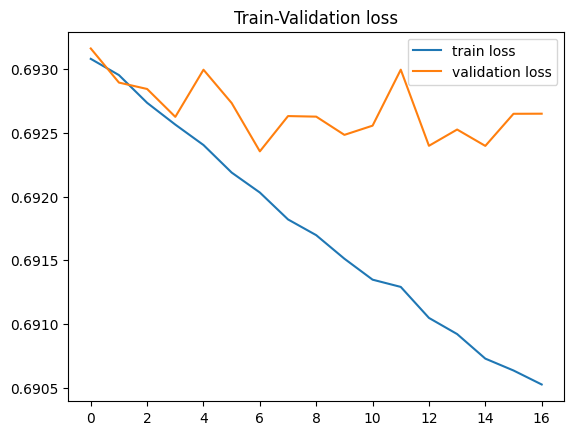

In [33]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as2'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.17447916666666666, 'precision': 0.17447916666666666, 'f1': 0.17447916666666666, 'accuracy': 0.17447916666666666}
FEMALE {'recall': 0.805, 'precision': 0.805, 'f1': 0.805, 'accuracy': 0.805} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.523989898989899, 'precision': 0.523989898989899, 'f1': 0.523989898989899, 'accuracy': 0.523989898989899}
MALE {'recall': 0.18248175182481752, 'precision': 0.18248175182481752, 'f1': 0.1824817518248175, 'accuracy': 0.18248175182481752}
FEMALE {'recall': 0.8923884514435696, 'precision': 0.8923884514435696, 'f1': 0.8923884514435696, 'accuracy': 0.8923884514435696} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5554106910039114, 'precision': 0.5554106910039114, 'f1': 0.5554106910039114, 'accuracy': 0.5554106910039114}
MALE {'recall': 0

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930873301594099 	 Validation loss: 0.6927741129519576 	 
  1%|          | 574/57400 [00:10<14:40, 64.56it/s]
Epoch 2 	 Training loss: 0.6928968666322556 	 Validation loss: 0.6931809358677622 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<14:41, 63.79it/s]
Epoch 3 	 Training loss: 0.692745536254258 	 Validation loss: 0.6932186878333657 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:51, 62.42it/s]
Epoch 4 	 Training loss: 0.6925631278690976 	 Validation loss: 0.6926769200017897 	 
  4%|▍         | 2296/57400 [00:40<14:17, 64.24it/s]
Epoch 5 	 Training loss: 0.6923552617586448 	 Validation loss: 0.6928084916987661 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:25, 63.00it/s]
Epoch 6 	 Training loss: 0.6921948844547471 	 Validation loss: 0.692843823109643 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:18, 62.84it/s]
Epoch 7 	 Training loss: 0.6920132148971956 	 Validation lo

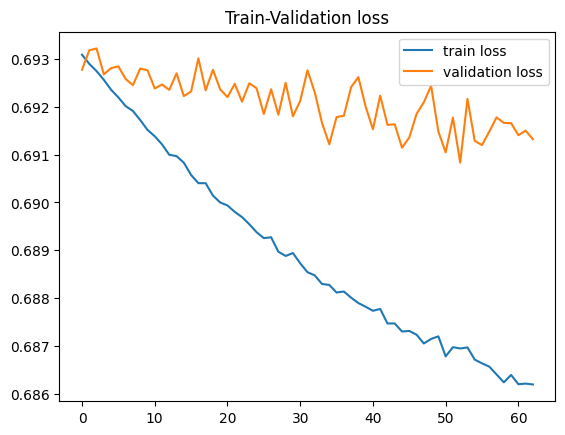

In [35]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as3'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47066326530612246, 'precision': 0.47066326530612246, 'f1': 0.47066326530612246, 'accuracy': 0.47066326530612246}
MALE {'recall': 0.5208333333333334, 'precision': 0.5208333333333334, 'f1': 0.5208333333333334, 'accuracy': 0.5208333333333334}
FEMALE {'recall': 0.4225, 'precision': 0.4225, 'f1': 0.4225, 'accuracy': 0.4225} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5959595959595959, 'precision': 0.5959595959595959, 'f1': 0.5959595959595959, 'accuracy': 0.5959595959595959}
MALE {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
FEMALE {'recall': 0.5013123359580053, 'precision': 0.5013123359580053, 'f1': 0.5013123359580053, 'accuracy': 0.5013123359580053} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6205997392438071, 'precision': 0.6205997392438071, 'f1': 0.6205997392438071, 'accuracy': 0.6205997392438071}
MALE {'recall': 

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4880952380952381, 'precision': 0.4880952380952381, 'f1': 0.4880952380952381, 'accuracy': 0.4880952380952381}
Métricas etiqueta male: {'recall': 0.359375, 'precision': 0.359375, 'f1': 0.359375, 'accuracy': 0.359375}
Métricas etiqueta female:  {'recall': 0.6116666666666667, 'precision': 0.6116666666666667, 'f1': 0.6116666666666667, 'accuracy': 0.6116666666666667}

 to
Resultado global: {'recall': 0.5707070707070707, 'precision': 0.5707070707070707, 'f1': 0.5707070707070707, 'accuracy': 0.5707070707070707}
Métricas etiqueta male: {'recall': 0.4622871046228711, 'precision': 0.4622871046228711, 'f1': 0.46228710462287104, 'accuracy': 0.4622871046228711}
Métricas etiqueta female:  {'recall': 0.6876640419947507, 'precision': 0.6876640419947507, 'f1': 0.6876640419947507, 'accuracy': 0.6876640419947507}

 as
Resultado global: {'recall': 0.5988700564971752, 'precision': 0.5988700564971752, 'f1': 0.5988700564971752, 'accuracy': 0.59887005